<img src="https://i.imgur.com/Y1CTNy9.jpeg">

# <b><span style='color:#F1A424'>|</span> DAIGT: <span style='color:#F1A424'>Text Classification</span><span style='color:#ABABAB'> [Train]</span></b> 

***


### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#loss">Loss Function</a></li>
<li><a href="#functions">Train and Validation Functions</a></li>
<li><a href="#train_loop">Train Loop</a></li>
<li><a href="#train">Train</a></li>
<li><a href="#evaluate">Evaluate</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Useful References</span></b>

- [Deberta v3 Hugging Face](https://huggingface.co/microsoft/deberta-v3-base)
- [Deberta paper](https://arxiv.org/abs/2006.03654)

# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [2]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings
import wandb


from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Current device is: cuda


### <b><span style='color:#F1A424'>Tokenizers and transformers</span></b>

In [3]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.13.3
transformers.__version__: 4.33.0


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [4]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 16
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 2e-5
    ENCODER_LR = 2e-5
    EPOCHS = 3
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=1000
    MAX_LEN = 512
    MIN_LR = 1e-6
    MODEL = "microsoft/deberta-v3-base"
    NUM_CYCLES = 0.5
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'cosine' # ['linear', 'cosine']
    SEED = 27
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    WANDB = False
    WEIGHT_DECAY = 0.01

    
class paths:
    OUTPUT_DIR = "/kaggle/working/output"
    EXTERNAL_DATA = "/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv"
    TRAIN_PROMPTS = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
    TRAIN_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
    TEST_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
    

if config.DEBUG:
    config.EPOCHS = 2
    config.TRAIN_FOLDS = [0]

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [5]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler
    

def get_score(y_trues, y_preds):
    score = roc_auc_score(y_trues, y_preds)
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

def sep():
    print("-"*100)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  
    
LOGGER = get_logger()
seed_everything(seed=config.SEED)

# <b><span style='color:#F1A424'>|</span> Weights and Biases 🐝</b><a class='anchor' id='wandb'></a> [↑](#top) 

***

Weights and Biases for tracking experiments.

In [6]:
import wandb

notes = ""

if config.WANDB:
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

    run = wandb.init(project='CommonLit', 
                     name="test_1",
                     config=get_config_dict(config),
                     group="anti_overfit",
                     job_type="train",
                     notes=notes,
                     anonymous=anony)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load data.

In [7]:
train_df = pd.read_csv(paths.TRAIN_ESSAYS, sep=',')
external_df = pd.read_csv(paths.EXTERNAL_DATA, sep=',')
train_prompts = pd.read_csv(paths.TRAIN_PROMPTS, sep=',')
print(f"Train essays dataframe has shape: {train_df.shape}"), sep()
print(f"External essays dataframe has shape: {external_df.shape}"), sep()
print(f"Train prompts dataframe has shape: {train_prompts.shape}"), sep()
display(train_df.head())
display(external_df.head())
display(train_prompts.head())

Train essays dataframe has shape: (1378, 4)
----------------------------------------------------------------------------------------------------
External essays dataframe has shape: (2421, 4)
----------------------------------------------------------------------------------------------------
Train prompts dataframe has shape: (2, 4)
----------------------------------------------------------------------------------------------------


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident..."
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


### <b><span style='color:#F1A424'>Add External Data</span></b>

In [8]:
external_df = external_df[["id", "source_text"]]
external_df.columns = ["id", "text"]
external_df['text'] = external_df['text'].str.replace('\n', '')
external_df["generated"] = 1
train_df.drop(columns=["prompt_id"],inplace=True)
train_df = pd.concat([train_df, external_df])
train_df.reset_index(inplace=True, drop=True)
print(f"Train dataframe has shape: {train_df.shape}"), sep()
train_df.head()

Train dataframe has shape: (3799, 3)
----------------------------------------------------------------------------------------------------


,id,text,generated
0,0059830c,Cars. Cars have been around since they became ...,0
1,005db917,Transportation is a large necessity in most co...,0
2,008f63e3,"""America's love affair with it's vehicles seem...",0
3,00940276,How often do you ride in a car? Do you drive a...,0
4,00c39458,Cars are a wonderful thing. They are perhaps o...,0


# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
X = train_df.loc[:, train_df.columns != "generated"]
y = train_df.loc[:, train_df.columns == "generated"]

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i
    
print(train_df.groupby("fold")["generated"].value_counts())
train_df.head()

fold  generated
0.0   1            485
      0            275
1.0   1            485
      0            275
2.0   1            485
      0            275
3.0   1            485
      0            275
4.0   1            484
      0            275
Name: count, dtype: int64


,id,text,generated,fold
0,0059830c,Cars. Cars have been around since they became ...,0,0.0
1,005db917,Transportation is a large necessity in most co...,0,0.0
2,008f63e3,"""America's love affair with it's vehicles seem...",0,0.0
3,00940276,How often do you ride in a car? Do you drive a...,0,0.0
4,00c39458,Cars are a wonderful thing. They are perhaps o...,0,0.0


# Tokenizer <a class='anchor' id='tokenizer'> [↑](#top)

In [10]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

    
We need to get the `max_len` from our `tokenizer`. We create a `tqdm` iterator and for each text we extract the tokenized length. Then we get the maximum value and we add 3 for the special tokens `CLS`, `SEP`, `SEP`.

- [Hugging Face Padding and Truncation](https://huggingface.co/docs/transformers/pad_truncation): check truncation to `max_length` or `True` (batch max length).

  0%|          | 0/3799 [00:00<?, ?it/s]

max_len: 512


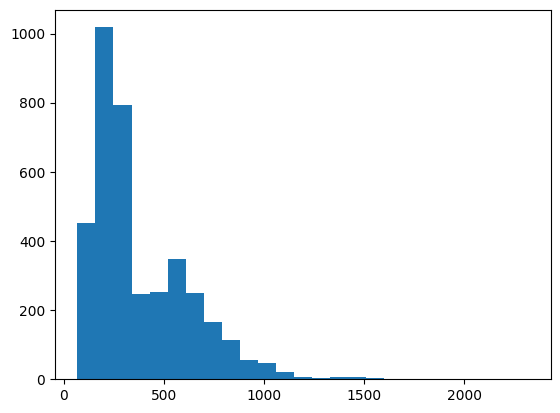

In [11]:
lengths = []
tqdm_loader = tqdm(train_df['text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [12]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch. 
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['generated'].values
        self.tokenizer = tokenizer
        self.text_ids = df['id'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.float) # TODO: check dtypes
        output["ids"] = self.text_ids[item]
        return output

One sample from the dataset should look as following:
```python
{
	'inputs': {
		'input_ids': tensor([1, 279, 883, ..., 0, 0]),
		'token_type_ids': tensor([0, 0, 0, ..., 0, 0]),
		'attention_mask': tensor([1, 1, 1, ..., 0, 0])
	},
	'label': tensor([0.0]),
	'ids': '000e8c3c7ddb'
}
```
You can check it by running the cell below.

In [13]:
if config.DEBUG:
    # ======== SPLIT ==========
    fold = 0
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['generated'].values

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # === Let's check one sample ===
    sample = train_dataset[0]
    print(f"Encoding keys: {sample.keys()} \n") 
    print(sample)

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [14]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        # Load config by inferencing it from the model name.
        if config_path is None: 
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)
        
        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()
          
        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
#         self._init_weights(self.head)
        
    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers 
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.head(feature)
        return output

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***
    
- [torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler): This class helps writing compute efficient training loops, so we dont get OOM errors. Also, one common error in any large deep learning model is the problem of underflowing gradients (i.e. your gradients are too small to take into account). `float16` tensors often don't take into account extremely small variations. To prevent this we can scale our gradients by some factor so that they aren't flushed to zero. Not to be confused with vanishing gradients, this gradients still might contribute to the learning process however are skipped because of computational limits.
- [torch.autocast](https://pytorch.org/docs/stable/amp.html#torch.autocast)

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] train loss": losses.val,
                           f"[fold_{fold}] lr": scheduler.get_lr()[0]})

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            ids = batch.pop("ids")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] val loss": losses.val})
                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["ids"] = ids
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [16]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)

    valid_labels = valid_folds['generated'].values

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR, 
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(optimizer_parameters,
                      lr=config.ENCODER_LR,
                      eps=config.EPS,
                      betas=config.BETAS)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-5,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        # ======= SCORING ==========
        score = get_score(valid_labels, sigmoid(predictions))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if config.WANDB:
            wandb.log({f"[fold_{fold}] epoch": epoch+1, 
                       f"[fold_{fold}] avg_train_loss": avg_loss, 
                       f"[fold_{fold}] avg_val_loss": avg_val_loss,
                       f"[fold_{fold}] score": score})
            
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(),
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")
            best_model_predictions = predictions

    valid_folds["preds"] = best_model_predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [ ]:
if __name__ == '__main__':
    def get_result(oof_df):
        labels = oof_df["generated"].values
        preds = oof_df["preds"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if config.TRAIN:
        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold == 0:
                _oof_df = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
    if config.WANDB:
        wandb.finish()

========== Fold: 0 training ==========


Train:   0%|          | 0/94 [00:00<?, ?train_batch/s]

Epoch: [1][0/94] Elapsed 0m 4s (remain 7m 32s) Loss: 0.8104 Grad: 499181.0312  LR: 0.00000043  
Epoch: [1][20/94] Elapsed 1m 6s (remain 3m 50s) Loss: 0.7420 Grad: 197359.3750  LR: 0.00000882  
Epoch: [1][40/94] Elapsed 2m 7s (remain 2m 45s) Loss: 0.6372 Grad: 77940.3438  LR: 0.00000993  


In [ ]:
oof_df["preds"] = oof_df["preds"].apply(lambda x: sigmoid(x))
oof_df

In [ ]:
!zip -r output.zip /kaggle/working/output